In [1]:
import os
import math
from tensorflow import keras
import numpy as np
import pandas as pd 



In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
import PIL
from tensorflow.keras import layers



for dirname, _, filenames in os.walk('./yoga'):
    print(dirname)


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
data_dir= "./yoga/TRAIN/"
data_dir2="./yoga/TEST/"

In [4]:
def removeCorruptedImages(path):
    for filename in os.listdir(path):
        try:
            img = Image.open(os.path.join(path,filename))
            img.verify() 
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            os.remove(os.path.join(path,filename))

In [5]:
batch_size = 32
img_height = 300
img_width = 300
epochs=30


In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1331 files belonging to 5 classes.
Using 1065 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir2,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 470 files belonging to 5 classes.
Using 94 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['downdog', 'goddess', 'plank', 'tree', 'warrior2']


In [9]:
len(class_names)

5

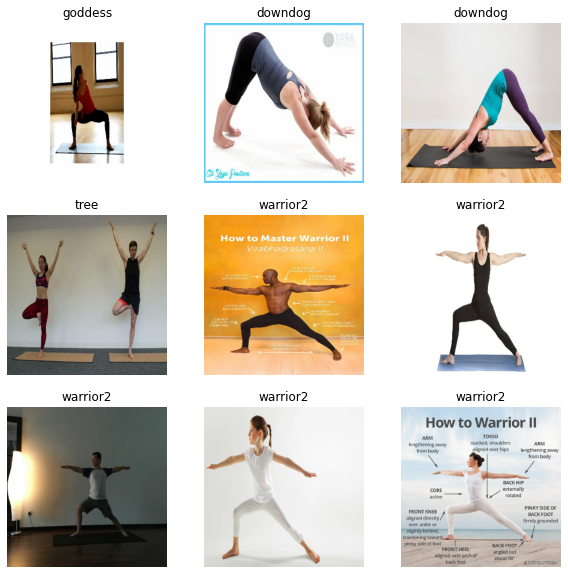

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('my-yoga-model-checkpoint.h5', verbose=1, save_best_only=True)

In [19]:
batch_size=32
history = model.fit(train_ds.repeat(),
                    steps_per_epoch=int(1065/batch_size),
                    epochs=25,
                    validation_data=val_ds.repeat(),
                    validation_steps=int(1065/batch_size),callbacks=[checkpoint])

Epoch 1/25
33/33 [==============================] - 98s 3s/step - loss: 2.5175 - accuracy: 0.2674 - val_loss: 1.4671 - val_accuracy: 0.4043

Epoch 00001: val_loss improved from inf to 1.46710, saving model to my-yoga-model-checkpoint.h5
Epoch 2/25
33/33 [==============================] - 77s 2s/step - loss: 1.3023 - accuracy: 0.4986 - val_loss: 1.0653 - val_accuracy: 0.6170

Epoch 00002: val_loss improved from 1.46710 to 1.06533, saving model to my-yoga-model-checkpoint.h5
Epoch 3/25
33/33 [==============================] - 88s 3s/step - loss: 0.8717 - accuracy: 0.6905 - val_loss: 0.9187 - val_accuracy: 0.6809

Epoch 00003: val_loss improved from 1.06533 to 0.91868, saving model to my-yoga-model-checkpoint.h5
Epoch 4/25
33/33 [==============================] - 78s 2s/step - loss: 0.5439 - accuracy: 0.8185 - val_loss: 1.1266 - val_accuracy: 0.6277

Epoch 00004: val_loss did not improve from 0.91868
Epoch 5/25
33/33 [==============================] - 64s 2s/step - loss: 0.2750 - accuracy

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

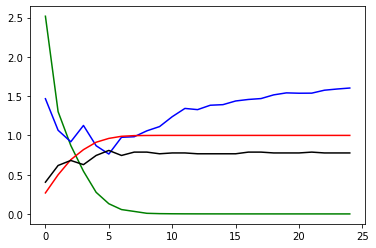

In [24]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'black')
plt.show()

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

(1672, 2508)
(300, 300)
This image most likely belongs to tree with a 100.00 percent confidence.


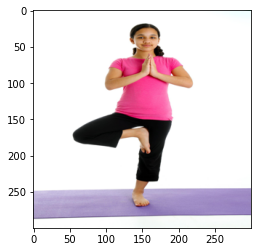

In [28]:
from PIL import Image
import io

byteImgIO = io.BytesIO()
#byteImgs
byteImg = Image.open("./yoga/TEST/00000005.jpg")
byteImg.save(byteImgIO, "JPEG")
byteImgIO.seek(0)
byteImg = byteImgIO.read()


dataBytesIO = io.BytesIO(byteImg)
# pose
pose=Image.open(dataBytesIO)
pose


print(pose.size)
pose=pose.resize((300,300))
print(pose.size)



img_array = keras.preprocessing.image.img_to_array(pose)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
plt.imshow(pose)


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.imshow(pose)